In [1]:
! pip install datasets 
! pip install transformers

     |████████████████████████████████| 346 kB 4.9 MB/s 
     |████████████████████████████████| 212 kB 57.3 MB/s 
     |████████████████████████████████| 1.1 MB 66.0 MB/s 
     |████████████████████████████████| 84 kB 3.5 MB/s 
     |████████████████████████████████| 140 kB 81.0 MB/s 
     |████████████████████████████████| 127 kB 72.9 MB/s 
     |████████████████████████████████| 144 kB 75.7 MB/s 
     |████████████████████████████████| 271 kB 75.3 MB/s 
     |████████████████████████████████| 94 kB 4.6 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 4.2 MB 4.8 MB/s 


In [2]:
from datasets import load_dataset
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import tensorflow as tf
from transformers import BertTokenizer
from tensorflow.keras.utils import to_categorical
from transformers import TFBertModel
from transformers import TFAutoModel
from tensorflow.keras import *
from tensorflow.keras import layers
from transformers import AutoConfig, AutoTokenizer, AutoModel, TFAutoModel
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn import metrics
import matplotlib.pyplot as plt

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [53]:
data = load_dataset("persiannlp/parsinlu_entailment")
df_train = pd.DataFrame(data['train'])
df_test = pd.DataFrame(data['test'])
df_valid = pd.DataFrame(data['validation'])

Reusing dataset parsinlu_reading_comprehension (/root/.cache/huggingface/datasets/persiannlp___parsinlu_reading_comprehension/parsinlu-repo/1.0.0/a99ad431d1637751f03fa9da3de66a41e93983d11116a0918a6efaaa72343d2d)


  0%|          | 0/3 [00:00<?, ?it/s]

In [30]:
df_test['label'].unique()

array(['c', 'n', 'e', '-'], dtype=object)

In [31]:
df_train['label'].unique()

array(['c', 'n', 'e', 'xx'], dtype=object)

In [32]:
df_valid['label'].unique()

array(['c', 'e', 'n'], dtype=object)

In [33]:
valid_labels = ['c','e','n']

In [4]:
class DataLoader:
  def __init__(self,tokenizer):
    self.tokenizer = tokenizer
    data = load_dataset("persiannlp/parsinlu_entailment")
    df_train = pd.DataFrame(data['train'])
    df_test = pd.DataFrame(data['test'])
    df_valid = pd.DataFrame(data['validation'])
    self.valid_labels = ['c','e','n']
    self.test_df = df_test[df_test['label'].isin(self.valid_labels)]
    self.train_df = df_train[df_train['label'].isin(self.valid_labels)]
    self.valid_df = df_valid[df_valid['label'].isin(self.valid_labels)]
    self.label_encoder = LabelEncoder()

  def generate_data(self):
    x_train1,y_train,x_test1,y_test,x_valid1,y_valid = self.split_data('sent1')
    x_train2,y_train,x_test2,y_test,x_valid2,y_valid = self.split_data('sent2')
    return zip(x_train1,x_train2),y_train,zip(x_test1,x_test2),y_test,zip(x_valid1,x_valid2),y_valid

  def split_data(self,column):
    x_train,y_train = self.train_df[column].values,to_categorical(self.label_encoder.fit_transform(self.train_df['label'].values),dtype = 'int32')
    x_test,y_test = self.test_df[column].values,to_categorical(self.label_encoder.transform(self.test_df['label'].values),dtype = 'int32')
    x_valid,y_valid = self.valid_df[column].values,to_categorical(self.label_encoder.transform(self.valid_df['label'].values),dtype = 'int32')
    return x_train,y_train,x_test,y_test,x_valid,y_valid

  def generate_bert_input(self,data,max_sequence_length=128):
    ids = []
    attn_masks = []
    for i,text in tqdm(enumerate(data)):
        tokenized_text = self.tokenizer.encode_plus(
            text[0],text[1],
            max_length = max_sequence_length,
            truncation = True,
            padding = 'max_length',
            add_special_tokens = True,
            return_tensors = 'tf'
        )
        ids.append(tokenized_text.input_ids[0])
        attn_masks.append(tokenized_text.attention_mask[0])
    return [np.array(ids),np.array(attn_masks)]


In [5]:
class Bert:

  def __init__(self,model_address):
    self.model_address = model_address
    self.tokenizer = AutoTokenizer.from_pretrained(self.model_address)
    try:
      self.bert = TFAutoModel.from_pretrained(self.model_address)
    except:
      self.bert = TFAutoModel.from_pretrained(self.model_address,from_pt=True)
    self.data_loader = DataLoader(self.tokenizer)

  def createBERTModel(self,max_length=128):
    input_ids = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="input_ids"
    )
    attention_masks = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="attention_masks"
    )
  
    self.bert.trainable = True
    bert_output = self.bert(input_ids, attention_mask=attention_masks)
    sequence_output = bert_output.last_hidden_state
    pooled_output = bert_output.pooler_output
    dropout = tf.keras.layers.Dropout(0.1)(pooled_output)
    output = layers.Dense(1024,activation="relu")(dropout)
    output = tf.keras.layers.Dense(3, activation="softmax")(output)
    self.model = tf.keras.models.Model(
        inputs=[input_ids, attention_masks], outputs=output
    )
    #self.model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=3e-5),loss='categorical_crossentropy',metrics=['accuracy'])
    print(self.model.summary())
    return self.model

  def train_model(self):
    self.model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=3e-5),loss='categorical_crossentropy',metrics=['accuracy'])
    x_train,y_train,x_test,y_test,x_valid,y_valid = self.data_loader.generate_data()
    train_data = self.data_loader.generate_bert_input(x_train)
    valid_data = self.data_loader.generate_bert_input(x_valid)
    self.history = self.model.fit(train_data, y_train,validation_data=(valid_data,y_valid),epochs=10, batch_size = 32)

  def plot_accuracy(self):
    plt.plot(self.history.history['accuracy'],label='train')
    plt.plot(self.history.history['val_accuracy'],label='validation')
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

  def eval_model(self):
    x_train,y_train,x_test,y_test,x_valid,y_valid = self.data_loader.generate_data()
    test_data = self.data_loader.generate_bert_input(x_test)
    predicted_y = self.model.predict(test_data)
    number_label_mapping = {0: 'c', 1:'e',2:'n'}
    y_test_conv = [number_label_mapping[np.argmax(val)] for val in y_test]
    predicted_y_conv = [number_label_mapping[np.argmax(val)] for val in predicted_y]
    print('Accuracy:', accuracy_score(y_test_conv, predicted_y_conv))
    print('Classification report:')
    print(classification_report(y_test_conv, predicted_y_conv))
    print('F1 (Micro):', f1_score(y_test_conv, predicted_y_conv, average='micro'))
    print('F1 (Macro):', f1_score(y_test_conv, predicted_y_conv, average='macro'))
    print('F1 (Weighted):', f1_score(y_test_conv, predicted_y_conv, average='weighted'))
    print('Recall (Micro):', recall_score(y_test_conv, predicted_y_conv, average='micro'))
    print('Recall (Macro):', recall_score(y_test_conv, predicted_y_conv, average='macro'))
    print('Recall (Weighted):', recall_score(y_test_conv, predicted_y_conv, average='weighted'))
    print('Precision (Micro):', precision_score(y_test_conv, predicted_y_conv, average='micro'))
    print('Precision (Macro):', precision_score(y_test_conv, predicted_y_conv, average='macro'))
    print('Precision (Weighted):', precision_score(y_test_conv, predicted_y_conv, average='weighted'))

## part2

In [6]:
xlm_model = Bert('xlm-roberta-base')
xlm_model.createBERTModel()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFXLMRobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing TFXLMRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFXLMRobertaModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.
Reusing dataset parsinlu_reading_comprehension (/root/.ca

  0%|          | 0/3 [00:00<?, ?it/s]

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 tfxlm_roberta_model (TFXLMRobe  TFBaseModelOutputWi  278043648  ['input_ids[0][0]',              
 rtaModel)                      thPoolingAndCrossAt               'attention_masks[0][0]']        
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                           

In [7]:
xlm_model.train_model()

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 1/10
24/24 [==============================] - 40s 1s/step - loss: 1.1011 - accuracy: 0.3714 - val_loss: 1.1233 - val_accuracy: 0.2889
Epoch 2/10
24/24 [==============================] - 23s 957ms/step - loss: 1.0972 - accuracy: 0.3886 - val_loss: 1.1029 - val_accuracy: 0.2889
Epoch 3/10
24/24 [==============================] - 23s 975ms/step - loss: 1.0913 - accuracy: 0.4151 - val_loss: 1.1349 - val_accuracy: 0.2889
Epoch 4/10
24/24 [==============================] - 23s 968ms/step - loss: 1.0915 - accuracy: 0.3674 - val_loss: 1.1720 - val_accuracy: 0.2889
Epoch 5/10
24/24 [==============================] - 23s 964ms/step - loss: 1.0845 - accuracy: 0.4019 - val_loss: 1.1304 - val_accuracy: 0.2889
Epoch 6/10
24/24 [==============================] - 23s 966ms/step - loss: 1.0618 - accuracy: 0.4204 - val_loss: 1.0876 - val_accuracy: 0.3815
Epoch 7/10
24/24 [==============================] - 23s 970ms/step - loss: 1.0313 - accuracy: 0.5053 - val_loss: 1.0958 - val_accuracy: 0.4444
Ep

0it [00:00, ?it/s]

Accuracy: 0.4823670053795577
Classification report:               precision    recall  f1-score   support

           c       0.59      0.36      0.45       561
           e       0.44      0.75      0.55       610
           n       0.51      0.29      0.37       502

    accuracy                           0.48      1673
   macro avg       0.51      0.47      0.46      1673
weighted avg       0.51      0.48      0.46      1673

F1 (Micro): 0.4823670053795577
F1 (Macro): 0.45828883896178757
F1 (Weighted): 0.4640955349387524
Recall (Micro): 0.4823670053795577
Recall (Macro): 0.46800201083396176
Recall (Weighted): 0.4823670053795577
Precision (Micro): 0.4823670053795577
Precision (Macro): 0.5125694589614822
Precision (Weighted): 0.5104368791379236


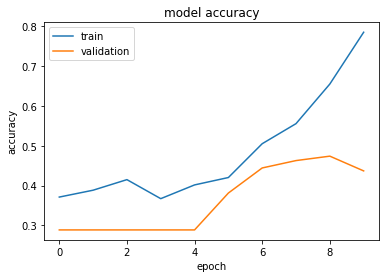

In [8]:
xlm_model.eval_model()
xlm_model.plot_accuracy()

## part3

In [8]:
pars_model = Bert('HooshvareLab/bert-base-parsbert-uncased')
pars_model.createBERTModel()

Some layers from the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at HooshvareLab/bert-base-parsbert-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
Reusing dataset parsinlu_reading_comprehension (/root/.cache/huggingface/datasets/persiannlp___parsinlu_reading_compreh

  0%|          | 0/3 [00:00<?, ?it/s]

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  162841344   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_masks[0][0]']        
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                         

In [9]:
pars_model.train_model()

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 1/10
24/24 [==============================] - 39s 1s/step - loss: 1.1037 - accuracy: 0.4151 - val_loss: 1.0542 - val_accuracy: 0.4444
Epoch 2/10
24/24 [==============================] - 22s 922ms/step - loss: 0.9216 - accuracy: 0.5663 - val_loss: 1.1814 - val_accuracy: 0.3852
Epoch 3/10
24/24 [==============================] - 22s 913ms/step - loss: 0.6123 - accuracy: 0.8103 - val_loss: 1.0873 - val_accuracy: 0.5296
Epoch 4/10
24/24 [==============================] - 22s 911ms/step - loss: 0.2881 - accuracy: 0.9231 - val_loss: 1.2859 - val_accuracy: 0.4889
Epoch 5/10
24/24 [==============================] - 22s 915ms/step - loss: 0.0931 - accuracy: 0.9867 - val_loss: 1.7134 - val_accuracy: 0.4963
Epoch 6/10
24/24 [==============================] - 22s 917ms/step - loss: 0.0227 - accuracy: 0.9987 - val_loss: 1.8914 - val_accuracy: 0.4926
Epoch 7/10
24/24 [==============================] - 22s 916ms/step - loss: 0.0126 - accuracy: 0.9987 - val_loss: 1.9962 - val_accuracy: 0.5000
Ep

0it [00:00, ?it/s]

Accuracy: 0.5218170950388523
Classification report:               precision    recall  f1-score   support

           c       0.52      0.44      0.48       561
           e       0.52      0.58      0.55       610
           n       0.52      0.54      0.53       502

    accuracy                           0.52      1673
   macro avg       0.52      0.52      0.52      1673
weighted avg       0.52      0.52      0.52      1673

F1 (Micro): 0.5218170950388523
F1 (Macro): 0.5194870845622264
F1 (Weighted): 0.5200366074846379
Recall (Micro): 0.5218170950388523
Recall (Macro): 0.5208152477220852
Recall (Weighted): 0.5218170950388523
Precision (Micro): 0.5218170950388523
Precision (Macro): 0.5216896539647516
Precision (Weighted): 0.5218743765024911


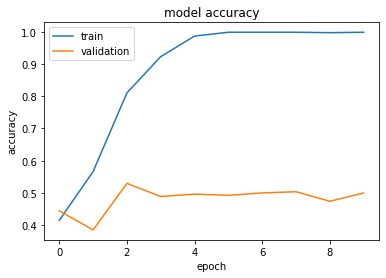

In [10]:
pars_model.eval_model()
pars_model.plot_accuracy()